In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# Load the Treasury data
data_path = "/DGS10.csv"
treasury_data = pd.read_csv(data_path, parse_dates=["DATE"], index_col="DATE")

# Clean the data by removing non-numeric values and converting columns to floats
treasury_data['DGS10'] = pd.to_numeric(treasury_data['DGS10'], errors='coerce')
treasury_data = treasury_data.dropna()

# Filter data from 2010 onwards for backtesting
treasury_data = treasury_data[treasury_data.index >= '2010-01-01']

# Scale the data using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
treasury_data_scaled = scaler.fit_transform(treasury_data.values)

# Convert scaled data back to DataFrame for ease of handling
treasury_data_scaled = pd.DataFrame(treasury_data_scaled, index=treasury_data.index, columns=treasury_data.columns)


In [14]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
data_values = treasury_data_scaled.values
X, y = create_sequences(data_values, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the LSTM model
input_dim = X_train.shape[2]
hidden_dim = 50
output_dim = 1
num_layers = 2
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Training loop for LSTM model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    lstm_model.train()
    outputs = lstm_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs.view(-1), y_train.view(-1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0432
Epoch [20/100], Loss: 0.0239
Epoch [30/100], Loss: 0.0188
Epoch [40/100], Loss: 0.0181
Epoch [50/100], Loss: 0.0161
Epoch [60/100], Loss: 0.0125
Epoch [70/100], Loss: 0.0046
Epoch [80/100], Loss: 0.0033
Epoch [90/100], Loss: 0.0024
Epoch [100/100], Loss: 0.0015


In [16]:
class MTKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_tasks=1):
        super(MTKAN, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.task_layers = nn.ModuleList([nn.Linear(hidden_dim, output_dim) for _ in range(num_tasks)])

    def forward(self, x):
        shared_representation = self.shared_layers(x)
        outputs = [task_layer(shared_representation) for task_layer in self.task_layers]
        return torch.stack(outputs, dim=1).squeeze()

# Initialize MT-KAN model
X_train_flat = X_train.view(X_train.size(0), -1)
X_test_flat = X_test.view(X_test.size(0), -1)

hidden_dim = 50
mtkan_model = MTKAN(input_dim=X_train_flat.shape[1], hidden_dim=hidden_dim, output_dim=1, num_tasks=1)

# Training loop for MT-KAN model
criterion_mtkan = nn.MSELoss()
optimizer_mtkan = torch.optim.Adam(mtkan_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    mtkan_model.train()
    outputs = mtkan_model(X_train_flat)
    optimizer_mtkan.zero_grad()
    loss = criterion_mtkan(outputs.view(-1), y_train.view(-1))
    loss.backward()
    optimizer_mtkan.step()

    if (epoch + 1) % 10 == 0:
        print(f'MT-KAN Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


MT-KAN Epoch [10/100], Loss: 0.0671
MT-KAN Epoch [20/100], Loss: 0.0017
MT-KAN Epoch [30/100], Loss: 0.0067
MT-KAN Epoch [40/100], Loss: 0.0018
MT-KAN Epoch [50/100], Loss: 0.0017
MT-KAN Epoch [60/100], Loss: 0.0011
MT-KAN Epoch [70/100], Loss: 0.0010
MT-KAN Epoch [80/100], Loss: 0.0008
MT-KAN Epoch [90/100], Loss: 0.0008
MT-KAN Epoch [100/100], Loss: 0.0007


In [17]:
# Inverse scale the predictions and actuals for evaluation
train_predict_lstm = scaler.inverse_transform(lstm_model(X_train).detach().numpy().reshape(-1, 1))
test_predict_lstm = scaler.inverse_transform(lstm_model(X_test).detach().numpy().reshape(-1, 1))
y_train_actual = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

train_predict_mtkan = scaler.inverse_transform(mtkan_model(X_train_flat).detach().numpy().reshape(-1, 1))
test_predict_mtkan = scaler.inverse_transform(mtkan_model(X_test_flat).detach().numpy().reshape(-1, 1))

# MSE, RMSE, MAE, R-squared
mse_test_lstm = mean_squared_error(y_test_actual, test_predict_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mae_test_lstm = mean_absolute_error(y_test_actual, test_predict_lstm)
r2_test_lstm = r2_score(y_test_actual, test_predict_lstm)

mse_test_mtkan = mean_squared_error(y_test_actual, test_predict_mtkan)
rmse_test_mtkan = np.sqrt(mse_test_mtkan)
mae_test_mtkan = mean_absolute_error(y_test_actual, test_predict_mtkan)
r2_test_mtkan = r2_score(y_test_actual, test_predict_mtkan)

print(f'LSTM Test MSE: {mse_test_lstm:.4f}, RMSE: {rmse_test_lstm:.4f}, MAE: {mae_test_lstm:.4f}, R^2: {r2_test_lstm:.4f}')
print(f'MT-KAN Test MSE: {mse_test_mtkan:.4f}, RMSE: {rmse_test_mtkan:.4f}, MAE: {mae_test_mtkan:.4f}, R^2: {r2_test_mtkan:.4f}')


LSTM Test MSE: 0.1115, RMSE: 0.3339, MAE: 0.2735, R^2: 0.7702
MT-KAN Test MSE: 0.0393, RMSE: 0.1982, MAE: 0.1639, R^2: 0.9190


In [18]:
# Calculate daily returns and Sharpe Ratio
def compute_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns)
    return mean_excess_return / std_excess_return

# Assuming daily returns for Sharpe Ratio calculation
daily_returns_lstm = np.diff(test_predict_lstm.flatten(), prepend=test_predict_lstm[0])
sharpe_ratio_lstm = compute_sharpe_ratio(daily_returns_lstm)

daily_returns_mtkan = np.diff(test_predict_mtkan.flatten(), prepend=test_predict_mtkan[0])
sharpe_ratio_mtkan = compute_sharpe_ratio(daily_returns_mtkan)

print(f'LSTM Sharpe Ratio: {sharpe_ratio_lstm:.4f}')
print(f'MT-KAN Sharpe Ratio: {sharpe_ratio_mtkan:.4f}')


LSTM Sharpe Ratio: 0.2984
MT-KAN Sharpe Ratio: 0.1869


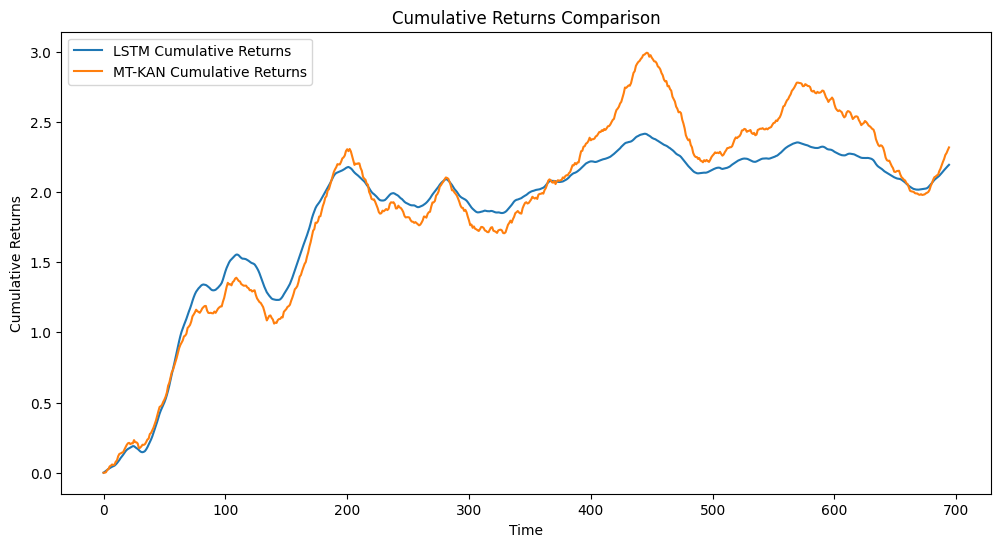

In [19]:
# Calculate cumulative returns
lstm_cumulative_returns = np.cumsum(daily_returns_lstm)
mtkan_cumulative_returns = np.cumsum(daily_returns_mtkan)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(lstm_cumulative_returns, label='LSTM Cumulative Returns')
plt.plot(mtkan_cumulative_returns, label='MT-KAN Cumulative Returns')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns Comparison")
plt.legend()
plt.show()
